# STEP2: Train model - Data 2020

In [1]:
cd ..

/home/ducbui/Documents/code_choi/MP


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve


In [3]:
df = pd.read_csv('final_data.csv')
df = df[df['YEAR'] == 2020]

In [4]:
df.head()

,CODE,NAME,STOCK EXCHANGE,YEAR,TARGET,EBIT,EBITDA,TOTAL EQUITY/TOTAL ASSETS,EPS,CASH/TOTAL CURRENT ASSETS,TOTAL CURRENT ASSET/TOTAL ASSET,LONG-TERM ASSETS/TOTAL ASSETS,QUICK RATIO,Market Value of Total Equity / Book Values of Total Liabilities,Sales/Total Assets,EBIT/Total Assets,Retain Earnings/Total Assets,Working Capitals/Total Asset,ROIC
574,AAA,CTCP Nhựa An Phát Xanh,1,2020,1.0,0.003813,0.004787,0.000003,0.000130,3.081309e-07,0.000184,0.000130,0.002485,0.001060,0.001166,0.000525,0.000515,0.000636,0.007666
575,AAM,CTCP Thủy sản MeKong,1,2020,0.0,-0.000086,-0.000051,0.000006,0.000000,2.203835e-07,0.000285,0.000051,0.011459,0.010559,0.000781,-0.000478,0.000156,0.005569,-0.007151
576,AAV,CTCP AAV Group,0,2020,0.0,0.000161,0.000179,0.000004,0.000042,1.271941e-08,0.000200,0.000118,0.003486,0.003381,0.000724,0.000316,0.000529,0.002321,0.004135
577,ABR,CTCP Đầu tư Nhãn hiệu Việt,1,2020,0.0,0.000221,0.000234,0.000005,0.000299,6.982841e-07,0.000247,0.000081,0.015808,0.016392,0.000467,0.000922,0.000826,0.004162,0.013875
578,ABS,CTCP Dịch vụ Nông nghiệp Bình Thuận,1,2020,1.0,0.000496,0.000421,0.000002,0.000088,4.249206e-09,0.000259,0.000071,0.003935,0.001568,0.001267,0.000500,0.000333,0.000837,0.010657


## Chia tập Train và Test

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(['TARGET', 'CODE', 'NAME', 'YEAR'], axis=1)
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(492, 15) (492,)
(123, 15) (123,)


In [6]:
# Completed training pipeline
completed_pl = Pipeline(
    steps=[
            ("classifier", RandomForestClassifier())
    ]
)

# training
completed_pl.fit(X_train, y_train)

# accuracy
y_train_pred = completed_pl.predict(X_train)
print(f"Accuracy on train: {accuracy_score(list(y_train), list(y_train_pred)):.2f}")

y_pred = completed_pl.predict(X_test)
print(f"Accuracy on test: {accuracy_score(list(y_test), list(y_pred)):.2f}")

Accuracy on train: 1.00
Accuracy on test: 0.93


In [7]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
import numpy as np

# Tính fbeta score
def fbeta(y_true, y_pred):
	return fbeta_score(y_true, y_pred, beta=np.sqrt(2))

In [8]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

# Xác định KFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# Xác định metric cho mô hình
metric = make_scorer(fbeta)
# Đánh giá mô hình
scores = cross_val_score(completed_pl, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
print('Mean Fbeta: {:.03f} {:.03f}'.format(np.mean(scores), np.std(scores)))

Mean Fbeta: 0.938 0.035


In [9]:
completed_pl = Pipeline(
    steps=[
            ("classifier", RandomForestClassifier())
    ]
)

In [10]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# list các mô hình được lựa chọn
models = {
  'LogisticRegression': LogisticRegression(),
  'GaussianNB': GaussianNB(),
  'KNeighborsClassifier': KNeighborsClassifier(),
  # 'SVM': SVC(),
  'MLPClassifier': MLPClassifier(),
  'DecisionTree': DecisionTreeClassifier(),
  'RandomForestClassifier': RandomForestClassifier(),
  'GDBoosting': GradientBoostingClassifier()
}

# Xác định KFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

all_scores = []
# Đánh giá toàn bộ các mô hình trên tập K-Fold đã chia
for key,model in models.items():
  completed_pl = Pipeline(
    steps=[('classifier', model)]
  )
  scores = cross_val_score(completed_pl, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
  models[key] = completed_pl.fit(X_train, y_train)
  y_pred = completed_pl.predict(X_test)
  y_scores = model.predict_proba(X_test)[:, 1] 
  report = classification_report(y_test, y_pred)
  # Tính AUROC
  auroc = roc_auc_score(y_test, y_scores)

  # Tính AUC-PR
  precision, recall, _ = precision_recall_curve(y_test, y_scores)
  auc_pr = auc(recall, precision)
  all_scores.append(scores)
  print(f"==========Model: {model}==========")
  print('Mean Fbeta: {:.03f} {:.03f}'.format(np.mean(scores), np.std(scores)))
  print(report)
  print(f"AUROC: {auroc}")
  print(f"AUC-PR: {auc_pr}")

==========Model: LogisticRegression()==========
Mean Fbeta: 0.582 0.075
              precision    recall  f1-score   support

         0.0       0.60      0.56      0.58        64
         1.0       0.56      0.59      0.57        59

    accuracy                           0.58       123
   macro avg       0.58      0.58      0.58       123
weighted avg       0.58      0.58      0.58       123

AUROC: 0.7473516949152541
AUC-PR: 0.7421811078396493
==========Model: GaussianNB()==========
Mean Fbeta: 0.874 0.045
              precision    recall  f1-score   support

         0.0       1.00      0.78      0.88        64
         1.0       0.81      1.00      0.89        59

    accuracy                           0.89       123
   macro avg       0.90      0.89      0.89       123
weighted avg       0.91      0.89      0.89       123

AUROC: 0.9700741525423728
AUC-PR: 0.9148669578715761
==========Model: KNeighborsClassifier()==========
Mean Fbeta: 0.803 0.057
              precision    rec

/home/ducbui/anaconda3/envs/tenso/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ducbui/anaconda3/envs/tenso/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ducbui/anaconda3/envs/tenso/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ducbui/anaconda3/envs/tenso/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

==========Model: MLPClassifier()==========
Mean Fbeta: 0.614 0.104
              precision    recall  f1-score   support

         0.0       0.73      0.73      0.73        64
         1.0       0.71      0.71      0.71        59

    accuracy                           0.72       123
   macro avg       0.72      0.72      0.72       123
weighted avg       0.72      0.72      0.72       123

AUROC: 0.8188559322033899
AUC-PR: 0.7697544219993596
==========Model: DecisionTreeClassifier()==========
Mean Fbeta: 0.945 0.038
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.94        64
         1.0       0.92      0.95      0.93        59

    accuracy                           0.93       123
   macro avg       0.93      0.94      0.93       123
weighted avg       0.94      0.93      0.93       123

AUROC: 0.9355137711864407
AUC-PR: 0.9457877865802833
==========Model: RandomForestClassifier()==========
Mean Fbeta: 0.937 0.034
              precisi

Text(0.5, 1.0, 'Scores Metrics')

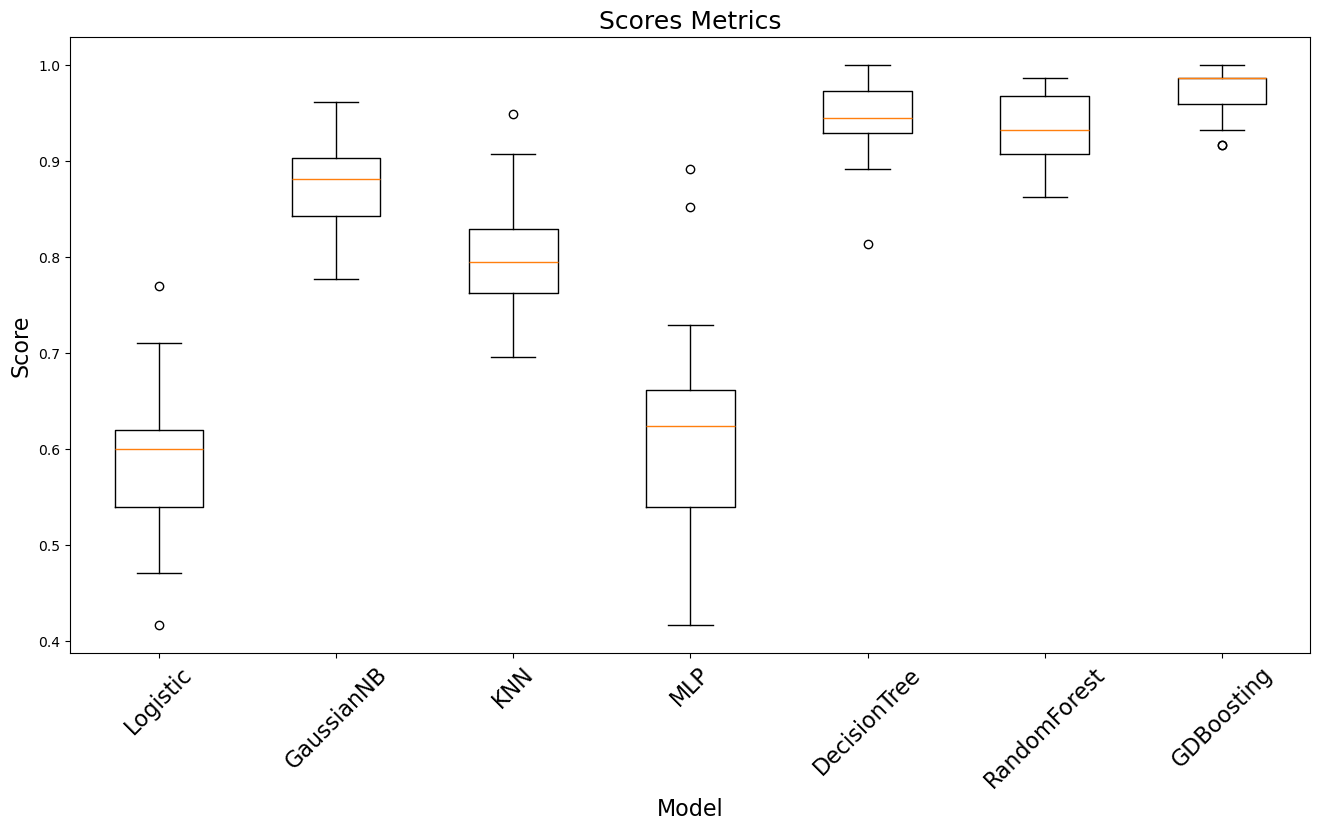

In [11]:
import matplotlib.pyplot as plt
model_names = ['Logistic', 'GaussianNB', 'KNN', 'MLP','DecisionTree', 'RandomForest', 'GDBoosting']

# Draw bboxplot 
plt.figure(figsize=(16, 8))
plt.boxplot(all_scores)
plt.xlabel('Model', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.xticks(np.arange(len(model_names))+1, model_names, rotation=45, fontsize=16)
plt.title("Scores Metrics", fontsize=18)

Nhìn vào biểu đồ ta có thể thấy GradientBoosting là thuật toán có độ chính xác cao nhất khi score trung bình đạt được khoảng 0.9, độ ổn định cao nên chúng ta sẽ lựa chọn lớp mô hình này để phát triển thành production.

## Grid Search

In [12]:
from sklearn.base import BaseEstimator
class ClassifierSwitcher(BaseEstimator):
  def __init__(
      self, 
      estimator = GradientBoostingClassifier(),
  ):
      """
      A Custom BaseEstimator that can switch between classifiers.
      :param estimator: sklearn object - The classifier
      """ 
      
      self.estimator = estimator


  def fit(self, X, y=None, **kwargs):
      self.estimator.fit(X, y)
      return self


  def predict(self, X, y=None):
      return self.estimator.predict(X)


  def predict_proba(self, X):
      return self.estimator.predict_proba(X)


  def score(self, X, y):
      return self.estimator.score(X, y)

In [13]:
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline(
    steps=[("clf", ClassifierSwitcher())]
)

In [14]:
parameters = [
    {
        'clf__estimator': [GradientBoostingClassifier()],
        # 'clf__estimator__n_estimators': [50, 100],
        # 'clf__estimator__max_depth': [3, 5, 10],
        # 'clf__estimator__criterion': ('gini', 'entropy', "friedman_mse",  "mae"),
        # 'clf__estimator__max_features': ('auto', 'sqrt', 'log2'),
        # 'clf__estimator__min_samples_split': np.linspace(0.1, 0.5, 12),
        # 'clf__estimator__min_samples_leaf': np.linspace(0.1, 0.5, 12),
        # 'clf__estimator__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
        # 'clf__estimator__subsample': [0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0]
        'clf__estimator__n_estimators': [50, 100],
        'clf__estimator__max_depth': [5, 10],
        'clf__estimator__criterion': ('gini', 'entropy', "friedman_mse",  "mae")
    },
]

In [15]:
metric = make_scorer(fbeta)
gscv = GridSearchCV(pipeline, parameters, cv=5, n_jobs=12, scoring=metric, return_train_score=True, error_score=0, verbose=3)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__criterion=gini, clf__estimator__max_depth=5, clf__estimator__n_estimators=50;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 2/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__criterion=gini, clf__estimator__max_depth=5, clf__estimator__n_estimators=50;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 3/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__criterion=gini, clf__estimator__max_depth=5, clf__estimator__n_estimators=50;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 5/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__criterion=gini, clf__estimator__max_depth=5, clf__estimator__n_estimators=50;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 4/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__criterion=gini, clf__estimator__max_depth=5, clf_

[CV 5/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__criterion=gini, clf__estimator__max_depth=10, clf__estimator__n_estimators=50;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 1/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__criterion=gini, clf__estimator__max_depth=10, clf__estimator__n_estimators=100;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 2/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__criterion=gini, clf__estimator__max_depth=10, clf__estimator__n_estimators=100;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 3/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__criterion=gini, clf__estimator__max_depth=10, clf__estimator__n_estimators=100;, score=(train=0.000, test=0.000) total time=   0.0s
[CV 4/5] END clf__estimator=GradientBoostingClassifier(), clf__estimator__criterion=gini, clf__estimator__max_depth=10, clf__estimator__n_estimators=100;, score=(train=0.000, te

/home/ducbui/anaconda3/envs/tenso/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
60 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ducbui/anaconda3/envs/tenso/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ducbui/anaconda3/envs/tenso/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/ducbui/anaconda3/envs/tenso/lib/python3.10/site-packages/sklearn/pipeline.py", line 475, in fit
  

GridSearchCV(cv=5, error_score=0,
             estimator=Pipeline(steps=[('clf', ClassifierSwitcher())]),
             n_jobs=12,
             param_grid=[{'clf__estimator': [GradientBoostingClassifier()],
                          'clf__estimator__criterion': ('gini', 'entropy',
                                                        'friedman_mse', 'mae'),
                          'clf__estimator__max_depth': [5, 10],
                          'clf__estimator__n_estimators': [50, 100]}],
             return_train_score=True,
             scoring=make_scorer(fbeta, response_method='predict'), verbose=3)

In [16]:
gscv.best_score_

0.9574092057410913

In [17]:
best_model = gscv.best_estimator_

In [18]:
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.95      0.92      0.94        64
         1.0       0.92      0.95      0.93        59

    accuracy                           0.93       123
   macro avg       0.93      0.94      0.93       123
weighted avg       0.94      0.93      0.93       123



In [19]:
import joblib
# Save the best_model pipeline object
joblib.dump(best_model, 'best_model.pkl')


['best_model.pkl']

## XGBoost training

In [20]:
from xgboost import XGBClassifier
# Initialize XGBoost classifier
xgboost_model = XGBClassifier()

# Perform cross-validation
scores = cross_val_score(xgboost_model, X, y, cv=5, scoring=metric)
xgboost_model.fit(X_train, y_train)
y_pred = xgboost_model.predict(X_test)
y_scores = xgboost_model.predict_proba(X_test)[:, 1] 
report = classification_report(y_test, y_pred)
# Tính AUROC
auroc = roc_auc_score(y_test, y_scores)

# Tính AUC-PR
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_pr = auc(recall, precision)
all_scores.append(scores)
print(f"==========Model: XGBoost==========")
print('Mean Fbeta: {:.03f} {:.03f}'.format(np.mean(scores), np.std(scores)))
print(report)
print(f"AUROC: {auroc}")
print(f"AUC-PR: {auc_pr}")

==========Model: XGBoost==========
Mean Fbeta: 0.960 0.013
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97        64
         1.0       0.95      0.98      0.97        59

    accuracy                           0.97       123
   macro avg       0.97      0.97      0.97       123
weighted avg       0.97      0.97      0.97       123

AUROC: 0.9960275423728814
AUC-PR: 0.995677721637481


## LightGBT Training


In [21]:
import lightgbm as lgb

# Convert data to LightGBM Dataset format
lgb_data = lgb.Dataset(X, label=y)

# Define parameters for LightGBM
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Perform cross-validation to train the model
cv_results = lgb.cv(params, lgb_data, num_boost_round=100, nfold=5, metrics='binary_error', seed=42)

# Train the final model with the best number of boosting rounds
best_num_boost_round = len(cv_results['valid binary_error-mean'])
lbg_model = lgb.train(params, lgb_data, num_boost_round=best_num_boost_round)

y_pred_prob = lbg_model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred = (y_pred_prob >= 0.5).astype(int)  # Assuming threshold of 0.5

y_scores = model.predict_proba(X_test)[:, 1] 
report = classification_report(y_test, y_pred)
# Tính AUROC
auroc = roc_auc_score(y_test, y_scores)

# Tính AUC-PR
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_pr = auc(recall, precision)
# all_scores.append(scores)
print(f"\n==========Model: LightGBT==========")
# print('Mean Fbeta: {:.03f} {:.03f}'.format(np.mean(scores), np.std(scores)))
print(report)
print(f"AUROC: {auroc}")
print(f"AUC-PR: {auc_pr}")

# # Print predictions
# print("Predicted classes:", y_pred)

# # Print cross-validation results
# print("Cross-validation results:", cv_results)
# print("Mean binary error:", np.mean(cv_results['valid binary_error-mean']))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 242, number of negative: 250
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2857
[LightGBM] [Info] Number of data points in the train set: 492, number of used features: 15
[LightGBM] [Info] Number of positive: 242, number of negative: 250
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2857
[LightGBM] [Info] Number of data points in the train set: 492, number of used features: 15
[LightGBM] [Info] Number of positive: 242, number of negative: 250
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remo

## CatBoost Training

In [22]:
from catboost import CatBoostClassifier
# Initialize XGBoost classifier
catboost_model = XGBClassifier()

# Perform cross-validation
scores = cross_val_score(catboost_model, X, y, cv=5, scoring=metric)
catboost_model.fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)
y_scores = catboost_model.predict_proba(X_test)[:, 1] 
report = classification_report(y_test, y_pred)
# Tính AUROC
auroc = roc_auc_score(y_test, y_scores)

# Tính AUC-PR
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_pr = auc(recall, precision)
all_scores.append(scores)
print(f"==========Model: CatBoost==========")
print('Mean Fbeta: {:.03f} {:.03f}'.format(np.mean(scores), np.std(scores)))
print(report)
print(f"AUROC: {auroc}")
print(f"AUC-PR: {auc_pr}")

==========Model: CatBoost==========
Mean Fbeta: 0.960 0.013
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97        64
         1.0       0.95      0.98      0.97        59

    accuracy                           0.97       123
   macro avg       0.97      0.97      0.97       123
weighted avg       0.97      0.97      0.97       123

AUROC: 0.9960275423728814
AUC-PR: 0.995677721637481


Text(0.5, 1.0, 'Scores Metrics')

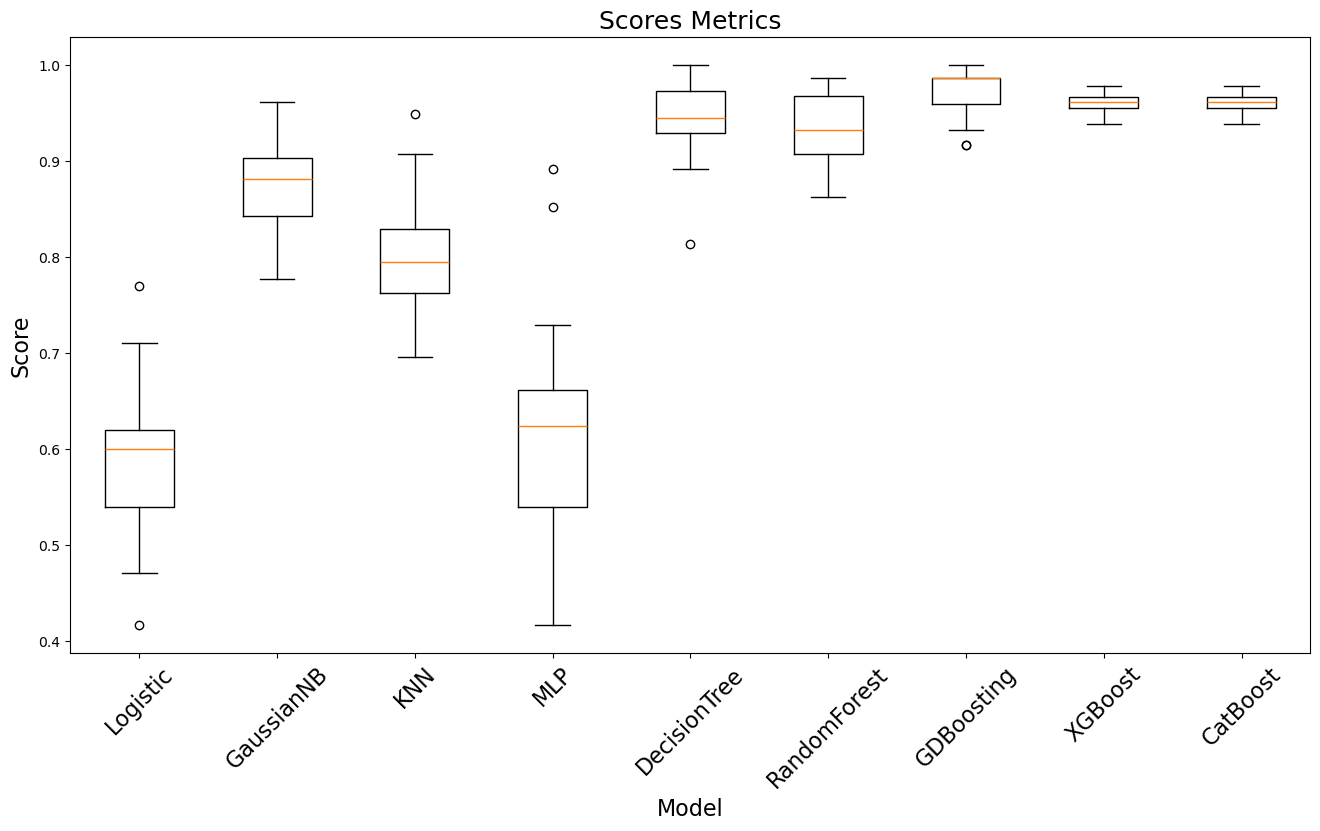

In [23]:
import matplotlib.pyplot as plt
model_names = ['Logistic', 'GaussianNB', 'KNN', 'MLP','DecisionTree', 'RandomForest', 'GDBoosting', 'XGBoost', 'CatBoost']

# Draw bboxplot 
plt.figure(figsize=(16, 8))
plt.boxplot(all_scores)
plt.xlabel('Model', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.xticks(np.arange(len(model_names))+1, model_names, rotation=45, fontsize=16)
plt.title("Scores Metrics", fontsize=18)